In [1]:
from catboost import CatBoostRegressor

In [18]:
import os
import random

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)

/home/jovyan/.mlspace/envs/kuzhamuratov-temporalmovqgan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
seed_everything(42)
n_samples = 500
top_left = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, 10]])
bottom_left = torch.randn((n_samples // 2, 2)) + torch.tensor([[-10, -10]])

x_0_dataset = torch.cat([top_left, bottom_left])


top_right = torch.randn((n_samples // 2, 2)) + torch.tensor([[+10, 10]])
bottom_right = torch.randn((n_samples // 2, 2)) + torch.tensor([[+10, -10]])

x_1_dataset = torch.cat([top_right, bottom_right])

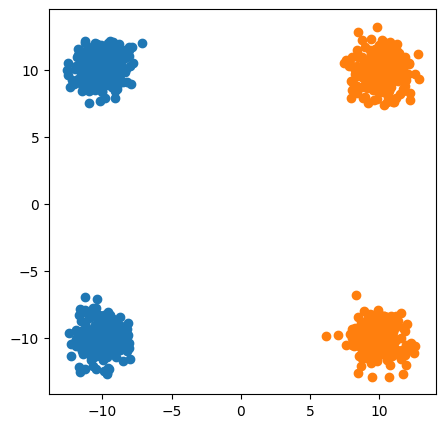

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0_dataset[:, 0], x_0_dataset[:, 1])
plt.scatter(x_1_dataset[:, 0], x_1_dataset[:, 1])

In [16]:
n_timesteps = 100
h = 1 / n_timesteps
timesteps = torch.arange(0, 1, h)
timesteps

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900])

In [38]:
batch_size = 128

In [39]:
models = []

for i in tqdm(range(n_timesteps)):
    t = timesteps[i]

    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]
    target = (x_1 - x_0)
    
    regressor = CatBoostRegressor(
        random_state=42,
        verbose=False,
        loss_function="MultiRMSE",
    )

    x_t = t * x_1 + (1 - t) * x_0

    regressor.fit(x_t.numpy(), target.numpy())

    models.append(regressor)

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [40]:
x_t = x_0_dataset.numpy()
x_ts = [x_t]

for model in tqdm(models):
    x_t = x_t + h * model.predict(x_t)
    x_ts.append(x_t)

100%|██████████| 100/100 [00:00<00:00, 708.76it/s]


100%|██████████| 500/500 [00:18<00:00, 27.57it/s]


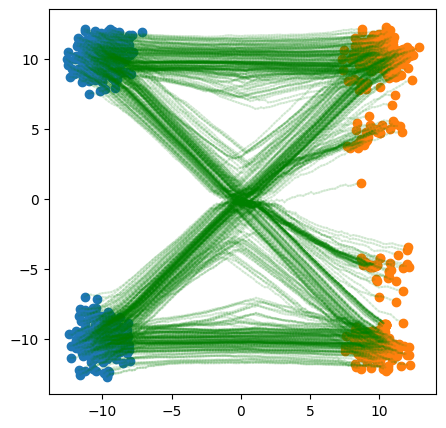

In [42]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0_dataset[:, 0], x_0_dataset[:, 1])
plt.scatter(x_t[:, 0], x_t[:, 1])

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()